# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 104.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import optuna
import json
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e6/train.csv"
    test_path = "/kaggle/input/playground-series-s5e6/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e6/sample_submission.csv"
    
    target = "Fertilizer Name"
    n_folds = 5
    seed = 42

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

cat_cols = train.select_dtypes(include="object").columns.tolist()
cat_cols = [c for c in cat_cols if c != CFG.target]
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")

label_encoder = LabelEncoder()
train[CFG.target] = label_encoder.fit_transform(train[CFG.target])

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

# Training base models

In [5]:
def map3(y_true, y_pred_probs):
    y_preds = np.argsort(y_pred_probs, axis=1)[:, ::-1][:, :3]

    score = 0
    for i in range(3):
        score += accuracy_score(y_true, y_preds[:, i]) / (i+1)

    return score

In [6]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test, fit_args={}):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], y.nunique()))
        test_pred_probs = np.zeros((X_test.shape[0], y.nunique()))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            
            if fit_args:
                model.fit(X_train, y_train, **fit_args, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if fit_args:
                print(f"\n--- Fold {fold_idx + 1} - MAP@3: {score:.6f}\n\n")
            else:
                print(f"--- Fold {fold_idx + 1} - MAP@3: {score:.6f}")
                            
        overall_score = map3(y, oof_pred_probs)
            
        print(f"\n------ Overall MAP@3: {overall_score:.6f} | Average MAP@3: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        return oof_pred_probs, test_pred_probs, scores

    def tune(self, X, y):        
        scores = []        
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)

In [7]:
lgbm_params = {
    "boosting_type": "gbdt",
    "device": "gpu",
    "colsample_bytree": 0.5,
    "n_estimators": 5000,
    "n_jobs": -1,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "device": "gpu",
    "colsample_bytree": 0.5,
    "n_estimators": 5000,
    "n_jobs": -1,
    "verbose": -1
}

xgb_params = {
    "early_stopping_rounds": 100,
    "device": "cuda",
    "enable_categorical": True,
    "learning_rate": 0.08,
    "colsample_bytree": 0.6,
    "subsample": 0.9,
    "gamma": 0.2,
    "reg_lambda": 0.2,
    "n_estimators": 5000,
    "n_jobs": -1,
    "verbosity": 0
}

cb_params = {
    "iterations": 5000,
    "task_type": "GPU",
    "verbose": False
}

In [8]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [9]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=250), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (gbdt)"], test_pred_probs["LightGBM (gbdt)"], scores["LightGBM (gbdt)"] = lgbm_trainer.fit_predict(X, y, X_test, fit_args)

Training LGBMClassifier



1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.9188
[500]	valid_0's multi_logloss: 1.91577
[750]	valid_0's multi_logloss: 1.91429
[1000]	valid_0's multi_logloss: 1.91401
Early stopping, best iteration is:
[980]	valid_0's multi_logloss: 1.91391

--- Fold 1 - MAP@3: 0.338383


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.9183
[500]	valid_0's multi_logloss: 1.91532
[750]	valid_0's multi_logloss: 1.91394
[1000]	valid_0's multi_logloss: 1.91342
Early stopping, best iteration is:
[910]	valid_0's multi_logloss: 1.91338

--- Fold 2 - MAP@3: 0.338827


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.91827
[500]	valid_0's multi_logloss: 1.915
[750]	valid_0's multi_logloss: 1.91378
Early stopping, best iteration is:
[848]	valid_0's multi_logloss: 1.91362

--- Fold 3 - MAP@3: 0.338499


Training until validation scores don't improve for 100 rounds
[250]	v

In [10]:
lgb_goss_model = LGBMClassifier(**lgbm_goss_params)
lgb_goss_trainer = Trainer(lgb_goss_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=250), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (goss)"], test_pred_probs["LightGBM (goss)"], scores["LightGBM (goss)"] = lgb_goss_trainer.fit_predict(X, y, X_test, fit_args)

Training LGBMClassifier

Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92664
Early stopping, best iteration is:
[204]	valid_0's multi_logloss: 1.92609

--- Fold 1 - MAP@3: 0.320374


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92607
Early stopping, best iteration is:
[235]	valid_0's multi_logloss: 1.92594

--- Fold 2 - MAP@3: 0.320868


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92572
Early stopping, best iteration is:
[208]	valid_0's multi_logloss: 1.92537

--- Fold 3 - MAP@3: 0.321777


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92613
Early stopping, best iteration is:
[267]	valid_0's multi_logloss: 1.92605

--- Fold 4 - MAP@3: 0.321146


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92645
Early stopping, best iteration is:
[216]	valid

In [11]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)

fit_args = {
    "verbose": 250
}

oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test, fit_args)

Training XGBClassifier

[0]	validation_0-mlogloss:1.94530
[250]	validation_0-mlogloss:1.91917
[500]	validation_0-mlogloss:1.91304
[750]	validation_0-mlogloss:1.91050
[1000]	validation_0-mlogloss:1.90931
[1250]	validation_0-mlogloss:1.90881
[1491]	validation_0-mlogloss:1.90888

--- Fold 1 - MAP@3: 0.345898


[0]	validation_0-mlogloss:1.94529
[250]	validation_0-mlogloss:1.91891
[500]	validation_0-mlogloss:1.91248
[750]	validation_0-mlogloss:1.90958
[1000]	validation_0-mlogloss:1.90824
[1250]	validation_0-mlogloss:1.90766
[1500]	validation_0-mlogloss:1.90751
[1652]	validation_0-mlogloss:1.90753

--- Fold 2 - MAP@3: 0.346788


[0]	validation_0-mlogloss:1.94529
[250]	validation_0-mlogloss:1.91860
[500]	validation_0-mlogloss:1.91218
[750]	validation_0-mlogloss:1.90938
[1000]	validation_0-mlogloss:1.90788
[1250]	validation_0-mlogloss:1.90729
[1375]	validation_0-mlogloss:1.90726

--- Fold 3 - MAP@3: 0.347116


[0]	validation_0-mlogloss:1.94529
[250]	validation_0-mlogloss:1.91934
[500]	validati

In [12]:
cb_model = CatBoostClassifier(**cb_params)
cb_trainer = Trainer(cb_model)

fit_args = {
    "verbose": 250,
    "early_stopping_rounds": 100,
    "use_best_model": True,
    "cat_features": cat_cols
}

oof_pred_probs["CatBoost"], test_pred_probs["CatBoost"], scores["CatBoost"] = cb_trainer.fit_predict(X, y, X_test, fit_args)

Training CatBoostClassifier

Learning rate set to 0.099306
0:	learn: 1.9450552	test: 1.9451515	best: 1.9451515 (0)	total: 5.74s	remaining: 7h 57m 49s
250:	learn: 1.9191413	test: 1.9295237	best: 1.9295237 (250)	total: 10.2s	remaining: 3m 13s
500:	learn: 1.9070171	test: 1.9260567	best: 1.9260567 (500)	total: 14.8s	remaining: 2m 13s
750:	learn: 1.8975367	test: 1.9243106	best: 1.9243106 (750)	total: 19.4s	remaining: 1m 49s
1000:	learn: 1.8883185	test: 1.9231883	best: 1.9231883 (1000)	total: 23.9s	remaining: 1m 35s
1250:	learn: 1.8797275	test: 1.9225358	best: 1.9225358 (1250)	total: 28.5s	remaining: 1m 25s
1500:	learn: 1.8716469	test: 1.9221613	best: 1.9221356 (1489)	total: 33.1s	remaining: 1m 17s
bestTest = 1.922132292
bestIteration = 1538
Shrink model to first 1539 iterations.

--- Fold 1 - MAP@3: 0.326094


Learning rate set to 0.099306
0:	learn: 1.9450490	test: 1.9450992	best: 1.9450992 (0)	total: 19.7ms	remaining: 1m 38s
250:	learn: 1.9195323	test: 1.9293210	best: 1.9293210 (250)	total

# Ensembling with LogisticRegression

In [13]:
X = pd.DataFrame(np.concatenate(list(oof_pred_probs.values()), axis=1))
X_test = pd.DataFrame(np.concatenate(list(test_pred_probs.values()), axis=1))

In [14]:
joblib.dump(X, "oof_pred_probs.pkl")
joblib.dump(X_test, "test_pred_probs.pkl")

['test_pred_probs.pkl']

In [15]:
lr_model = LogisticRegression(**{
    'random_state': CFG.seed,
    'max_iter': 500,
    'C': 2.241899603250816,
    'tol': 0.0025920949567029227,
    'fit_intercept': True,
    'class_weight': None,
    'solver': 'liblinear',
    'penalty': 'l2'
})
lr_trainer = Trainer(lr_model)

_, lr_test_pred_probs, scores["LogisticRegression"] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - MAP@3: 0.345780
--- Fold 2 - MAP@3: 0.346832
--- Fold 3 - MAP@3: 0.347506
--- Fold 4 - MAP@3: 0.346663
--- Fold 5 - MAP@3: 0.346476

------ Overall MAP@3: 0.346651 | Average MAP@3: 0.346651 ± 0.000557


In [16]:
final_predictions = []
for i in np.argsort(lr_test_pred_probs)[:,-3:][::-1]:
    prediction = label_encoder.inverse_transform(i)
    final_predictions.append(" ".join(prediction))

In [17]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = final_predictions
sub.to_csv(f"sub_logistic-regression_{np.mean(scores['LogisticRegression']):.6f}.csv", index=False)
sub.head()

,id,Fertilizer Name
0,750000,20-20 17-17-17 14-35-14
1,750001,DAP 28-28 10-26-26
2,750002,10-26-26 14-35-14 DAP
3,750003,17-17-17 10-26-26 14-35-14
4,750004,Urea 28-28 17-17-17


# Results

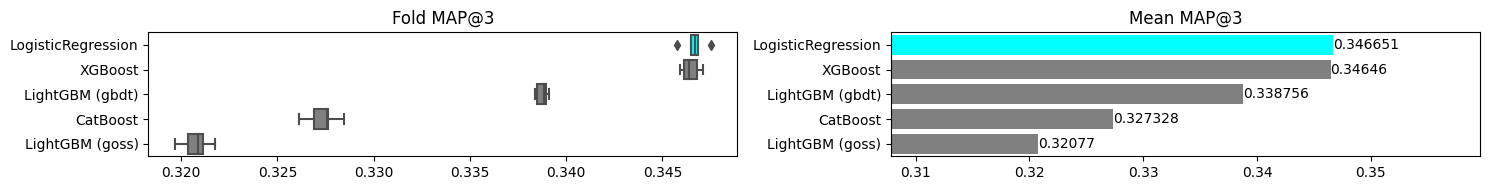

In [18]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "logistic" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()